In [1]:
!pip3 install transformers
!pip3 install datasets
!pip3 install nltk
!pip3 install pyspellchecker

In [2]:
from transformers import RobertaForSequenceClassification, RobertaTokenizerFast, RobertaModel, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score
 

DEVICE = torch.device("cuda")

In [3]:
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=1, hidden_dropout_prob=0.05).to(DEVICE)
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

In [5]:
import nltk
from spellchecker import SpellChecker
spellch = SpellChecker()
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append("user")

def clean_string(s):
#     s = " ".join(word for word in s.split() if word not in stopwords)
    s = s.encode('ASCII', 'ignore').decode()
    s = s.lower()
    s = ''.join([ch for ch in s if ch.isalpha() or ch == ' '])
    s = " ".join(s.split())
    if len(s) > 0 and s[-1] == ' ':
        s = s[:-1]
    if len(s) > 0 and s[0] == ' ':
        s = s[1:]
    
    # corrected = []
    # misspelled = spellch.unknown(s.split())
    # for word in s.split():
    #     if word in misspelled:
    #         corrected.append(spellch.correction(word))
    #         print(word, corrected[-1])
    #     else:
    #         corrected.append(word)
    # s = " ".join(corrected)
    return s

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ilia509/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
from datasets import load_dataset

dataset = load_dataset("tweets_hate_speech_detection")

def cleaned(data):
     tweets = [] 
     for tweet in data['tweet']:
         tweets.append(clean_string(tweet))
     return {'cleaned': tweets}
cleaned_dataset = dataset.map(cleaned, batched=True)


train_size = int(len(cleaned_dataset["train"]) * 0.8)
val_size = len(cleaned_dataset["train"]) - train_size
train_data, val_data = random_split(cleaned_dataset["train"], [train_size, val_size], generator=torch.Generator().manual_seed(42))

In [8]:
toxic_tweets = sum(train_data[:]['label'])
print(toxic_tweets, train_size)
print(toxic_tweets / train_size)

1787 25569
0.06988931909734444


In [9]:
from torch.utils.data import WeightedRandomSampler

batch_size = 32
# multiplier = 2    # m * t / (m * t + n)
# weights = torch.ones(train_size) + (multiplier - 1) * torch.tensor(train_data[:]['label'])
# sampler = WeightedRandomSampler(weights, train_size)
# train_loader = DataLoader(train_data, batch_size=batch_size, sampler=sampler)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [6]:
optim = torch.optim.AdamW(model.parameters(), lr=1e-5, eps = 1e-8)
# optim = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()

In [7]:
THRESHOLD = 0.7721518987341772

def evaluate():
    model.eval()
    with torch.no_grad():
      correct = 0
      processed = 0
      running_loss = 0
      for i in val_loader:
          tweet = i["cleaned"]
          label = i["label"]
          tokens = tokenizer(tweet, padding=True, truncation=True,  return_tensors="pt").to(DEVICE)
          outputs = model.forward(**tokens)[0]
          result = torch.sigmoid(outputs) > THRESHOLD
          correct += accuracy_score(label, result.cpu(), normalize=False)
          processed += len(label)

          loss = criterion(outputs, label.type_as(outputs).unsqueeze(1))
          running_loss += loss.item() * len(label)

    return running_loss / processed, correct / processed

# оценим до обучения
# print(evaluate()) # 0.07117159393086188

In [12]:
def train(epoch):
    running_loss = 0
    processed = 0
    correct = 0
    model.train()
    for i in train_loader:
        tweet = i["cleaned"]
        label = i["label"].to(DEVICE)
        optim.zero_grad()
        tokens = tokenizer(tweet, padding=True, truncation=True,  return_tensors="pt").to(DEVICE)
        outputs = model.forward(**tokens)[0]

        loss = criterion(outputs, label.type_as(outputs).unsqueeze(1))
        loss.backward()
        optim.step()

        result = torch.sigmoid(outputs) > THRESHOLD
        correct += accuracy_score(label.cpu(), result.cpu(), normalize=False)

        running_loss += loss.item() * len(label)
        processed += len(label)

        scheduler.step()
    
    return running_loss / processed, correct / processed


In [8]:
scheduler = get_linear_schedule_with_warmup(optim, 250 * 2, 250 * 8)

In [14]:
for epoch in range(0, 5):
  train_loss, train_acc = train(epoch)
  eval_loss, eval_acc = evaluate()
  print(epoch, train_loss, train_acc, eval_loss, eval_acc)
  if epoch % 1 == 0:
    torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optim.state_dict()
          }, f'modelState{epoch}.pth')

0 0.2036021706274316 0.8703899253001681 0.11078681466390358 0.9587048334115439
1 0.08695642724852853 0.9686730024639212 0.0977811122245547 0.9624589394650399
2 0.05329786681623401 0.9813054871133012 0.10850443769914712 0.9637103081495385
3 0.047556713211510296 0.9842387265829715 0.10850443672368397 0.9637103081495385
4 0.04788764724641604 0.9834174195314639 0.1085044366118029 0.9637103081495385


In [15]:
model_answers = torch.tensor([])
true_answers = torch.tensor([])
model.eval()
processed = 0

for i in val_loader:
    with torch.no_grad():
        tweet = i["cleaned"]
        label = i["label"]
        tokens = tokenizer(tweet, padding=True, truncation=True,  return_tensors="pt").to(DEVICE)
        outputs = model.forward(**tokens) 
        result = torch.sigmoid(outputs[0])
        model_answers = torch.cat((model_answers, result.squeeze(1).cpu()))
        true_answers = torch.cat((true_answers, label))

        processed += len(label)

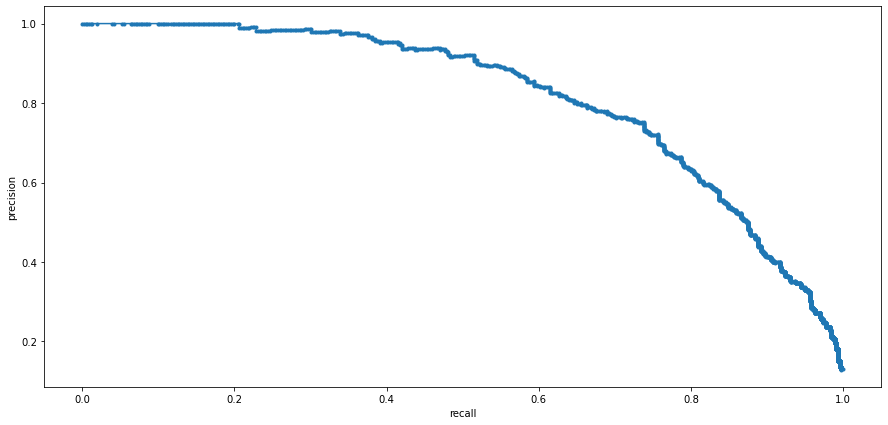

In [16]:
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve

prc = precision_recall_curve(true_answers.detach().numpy(), model_answers.detach().numpy(), pos_label = 1)
pyplot.figure(figsize=(15,7))
pyplot.plot(prc[1], prc[0], marker='.')

# for x, y, z in zip(prc[1], prc[0], prc[2]):
#     label = "{:.1f}".format(1 - z)
#     pyplot.annotate(label, 
#                  (x,y), 
#                  textcoords="offset points",
#                  xytext=(0,10), 
#                  ha='center')

pyplot.xlabel('recall')
pyplot.ylabel('precision')
pyplot.show()


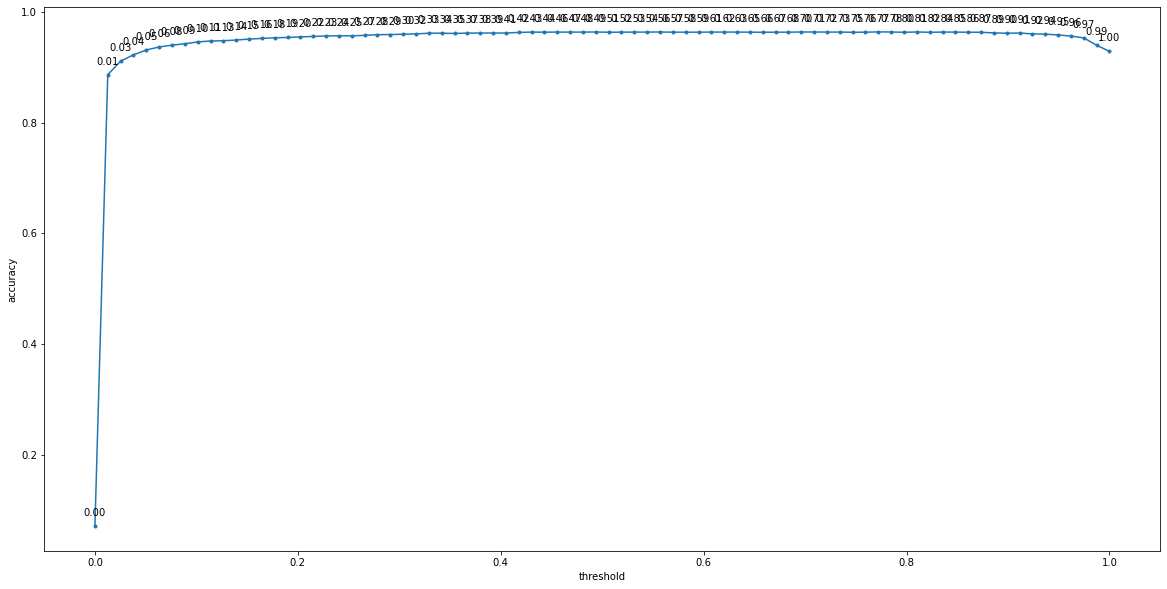

0.7721518987341772 0.9640231503206632


In [17]:
import numpy as np

xs = []
ys = []
mxthr = 0
mx = 0

for thr in np.linspace(0,1,80):
    score = accuracy_score(true_answers, model_answers > thr)
    xs.append(thr)
    ys.append(score)
    if score > mx:
        mx = score
        mxthr = thr

pyplot.figure(figsize=(20,10))
pyplot.plot(xs, ys, marker='.')

for x, y in zip(xs, ys):

    label = "{:.2f}".format(x)

    pyplot.annotate(label, 
                 (x,y), 
                 textcoords="offset points",
                 xytext=(0,10), 
                 ha='center')

pyplot.xlabel('threshold')
pyplot.ylabel('accuracy')
pyplot.show()

print(mxthr, mx)

In [19]:
ans = model_answers > THRESHOLD
tp = 0
fp = 0
tn = 0
fn = 0

for mansw, answ in zip(ans, true_answers):
    if answ == 1 and mansw == 1:
        tp += 1
    if answ == 0 and mansw == 0:
        tn += 1
    if answ == 1 and mansw == 0:
        fp += 1
    if answ == 0 and mansw == 1:
        fn += 1

print(tp, fp)
print(tn, fn)

280 175
5883 55


361 94
5800 138

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [9]:
# checkpoint = torch.load('drive/MyDrive/modelState199.pth')
checkpoint = torch.load('modelState4.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optim.load_state_dict(checkpoint['optimizer_state_dict'])

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
toxic_tweets = []
for data in val_data:
    if data['label'] == 1:
        toxic_tweets.append(data)

In [ ]:
count = 0
for tweet in toxic_tweets:
    fixed_tweet = tweet['cleaned']
    # fixed_tweet = " ".join(tweet.split())
    model.eval()
    tokens = tokenizer(fixed_tweet, padding=True, truncation=True,  return_tensors="pt").to(DEVICE)
    outputs = model.forward(**tokens)[0] 
    result = torch.sigmoid(outputs)
    if (result > THRESHOLD) == 0:  
        print(result.item(), (result > THRESHOLD).item())
        print(tweet['tweet'])
        print(tweet['cleaned'])
        count += 1
        # break
print(count)

In [20]:
not_toxic_tweets = []
for data in val_data:
    if data['label'] == 0:
        not_toxic_tweets.append(data)

In [21]:
count = 0
for tweet in not_toxic_tweets:
    fixed_tweet = tweet['cleaned']
    # fixed_tweet = " ".join(tweet.split())
    model.eval()
    tokens = tokenizer(fixed_tweet, padding=True, truncation=True,  return_tensors="pt").to(DEVICE)
    outputs = model.forward(**tokens)[0] 
    result = torch.sigmoid(outputs)
    if (result > THRESHOLD) == 1:  
        print(result.item(), (result > THRESHOLD).item())
        print(tweet['tweet'])
        print(tweet['cleaned'])
        count += 1
        # break
print(count)

0.9046435952186584 True
#obama #attacks #trump on #islamâ¦ #trump #dismantles him with one # ... -  
obama attacks trump on islam trump dismantles him with one
0.8704006671905518 True
days porn movie pussy pay pics  
days porn movie pussy pay pics
0.9312804341316223 True
#governance #feminism gets to be  ? 
governance feminism gets to be
0.8447762727737427 True
#interracialdating how are you? see you? -  
interracialdating how are you see you
0.9672583341598511 True
@user @user news: carson uses word 'fairness' #trumpswiddleblackbuddy #usedbytrump  
user user news carson uses word fairness trumpswiddleblackbuddy usedbytrump
0.7730200290679932 True
@user hey #brexit / #leave #xenophobes - tell us how #economy affected / #growth forecasts etc if uk leave #eu ? no? just less #iâ¦
user hey brexit leave xenophobes tell us how economy affected growth forecasts etc if uk leave eu no just less i
0.9566429853439331 True
wrestler invited a #punjabi kudi in ... -    #shocking #viral #woman #wt 

0.8436033129692078 True
trump campaign: female judges could be biased, too he must hate women   
trump campaign female judges could be biased too he must hate women
0.8947588205337524 True
 @user europe proves that "diversity &amp; multiculturalism" bring violence, rape &amp; ruin to our white, western countries. 
user europe proves that diversity amp multiculturalism bring violence rape amp ruin to our white western countries
0.9589217305183411 True
ð   south sudan allowed soldiers to rape as wages : un  
south sudan allowed soldiers to rape as wages un
0.9302417039871216 True
zadiq khan should be sacked over this it's insulting to us british 
zadiq khan should be sacked over this its insulting to us british
0.9255536198616028 True
women used to be responsible for men's behavior.   
women used to be responsible for mens behavior
0.9858360290527344 True
@user .you're talking about obama 
user youre talking about obama
0.9057151675224304 True
shocked by what's considered racist these